In [1]:
# Linting - using black
# # %load_ext nb_black
# %load_ext lab_black

# Autoreload modules
%load_ext autoreload
%autoreload 2

In [2]:
pip install climpred[complete]

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Import third-party libraries
import xarray as xr
import climpred

xr.set_options(display_style="html")

# silence warnings if annoying
import warnings
warnings.filterwarnings("ignore")

/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Import tqdm
import tqdm

In [5]:
import intake

In [6]:
import intake_esm

In [7]:
# import dask_gateway

# # Create a connection to dask-gateway.
# gw = dask_gateway.Gateway("https://dask-gateway.jasmin.ac.uk", auth="jupyterhub")

# # Inspect and change the options if required before creating your cluster.
# options = gw.cluster_options()
# options.worker_cores = 2

# # Create a dask cluster, or, if one already exists, connect to it.
# # This stage creates the scheduler job in SLURM, so may take some time.
# # While your job queues.
# clusters = gw.list_clusters()
# if not clusters:
#     cluster = gw.new_cluster(options, shutdown_on_close=False)
# else:
#     cluster = gw.connect(clusters[0].name)

# # Create at least one worker, and allow your cluster to scale to three.
# cluster.adapt(minimum=1, maximum=3)

# # Get a dask client.
# client = cluster.get_client()

In [8]:
col = intake.open_esm_datastore(
    "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [9]:
dsd = (intake.cat.nci.esgf.cmip6.search(source_id='ACCESS-CM2', experiment_id='historical', variable_id='tas', member_id='r1i1p1f1', table_id='Amon')
       .to_dataset_dict(cdf_kwargs={'chunks': {'time': 120}}))
ds_cmip = list(dsd.values())[0]

AttributeError: nci

In [9]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [14]:
# Constrain col to experiment_id = ["dcppA-hincast"]
variable_id = "pr"
table_id = "Amon"
# source_id = "CESM1-1-CAM5-CMIP5"
inits = list(np.arange(1961, 2015))
cat_cmip = col.search(
    experiment_id=["dcppA-hindcast"],
    table_id=table_id,
    variable_id=variable_id,
    dcpp_init_year=inits,
)

cat_cmip.df["dcpp_init_year"] = cat_cmip.df.dcpp_init_year.astype(int)

In [15]:
cat_cmip

,unique
activity_id,1
institution_id,3
source_id,3
experiment_id,1
member_id,40
table_id,1
variable_id,1
grid_label,1
zstore,2002
dcpp_init_year,54


In [16]:
# print all of the different source_ids
# Print all unique source_ids in the cat_CMIP DataFrame
print(cat_cmip.df['source_id'].unique())

['CanESM5' 'MIROC6' 'NorCPM1']


In [13]:
cat_cmip.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,DCPP,CCCma,CanESM5,dcppA-hindcast,r18i1p2f1,Amon,ua,gn,gs://cmip6/DCPP/CCCma/CanESM5/dcppA-hindcast/s...,2007,20190429
1,DCPP,CCCma,CanESM5,dcppA-hindcast,r19i1p2f1,Amon,ua,gn,gs://cmip6/DCPP/CCCma/CanESM5/dcppA-hindcast/s...,2007,20190429
2,DCPP,CCCma,CanESM5,dcppA-hindcast,r16i1p2f1,Amon,ua,gn,gs://cmip6/DCPP/CCCma/CanESM5/dcppA-hindcast/s...,2007,20190429
3,DCPP,CCCma,CanESM5,dcppA-hindcast,r17i1p2f1,Amon,ua,gn,gs://cmip6/DCPP/CCCma/CanESM5/dcppA-hindcast/s...,2007,20190429
4,DCPP,CCCma,CanESM5,dcppA-hindcast,r3i1p2f1,Amon,ua,gn,gs://cmip6/DCPP/CCCma/CanESM5/dcppA-hindcast/s...,2007,20190429


In [14]:
! pip install gcsfs

Defaulting to user installation because normal site-packages is not writeable


In [15]:
import gcsfs

In [16]:
# Preprocess the datasets
def preprocess(ds):
    # make time dim identical
    ds = climpred.shared.set_integer_time_axis(ds, time_dim="time")
    return ds


dsets = cat_cmip.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "use_cftime": True},
    preprocess=preprocess,
)
[key for key in dsets]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['DCPP.CCCma.CanESM5.dcppA-hindcast.Amon.gn']

In [17]:
hindcast = dsets["DCPP.CCCma.CanESM5.dcppA-hindcast.Amon.gn"]
hindcast = hindcast[variable_id].squeeze()
hindcast

,Array,Chunk
Bytes,75.15 GiB,35.62 MiB
Shape,"(20, 54, 120, 19, 64, 128)","(1, 1, 60, 19, 64, 128)"
Count,14040 Tasks,2160 Chunks
Type,float32,numpy.ndarray


In [18]:
# Rename dimensions to be the same as the climpred dimensions
hindcast = climpred.shared.rename_to_climpred_dims(hindcast)

In [19]:
hindcast

,Array,Chunk
Bytes,75.15 GiB,35.62 MiB
Shape,"(20, 54, 120, 19, 64, 128)","(1, 1, 60, 19, 64, 128)"
Count,14040 Tasks,2160 Chunks
Type,float32,numpy.ndarray


In [20]:
# Set up arbitrary dates
init = "1961-12-16"

# Set up arbitrary dates
hindcast["lead"] = xr.cftime_range(start=init, freq="MS", periods=hindcast.lead.size)

hindcast

,Array,Chunk
Bytes,75.15 GiB,35.62 MiB
Shape,"(20, 54, 120, 19, 64, 128)","(1, 1, 60, 19, 64, 128)"
Count,14040 Tasks,2160 Chunks
Type,float32,numpy.ndarray


In [21]:
# Group by season - JJA
hindcast_ = hindcast.lead.dt.month.isin([6, 7, 8])

hindcast_

# Constrain to JJA
hindcast_JJA = hindcast.sel(lead=hindcast_)

In [22]:
hindcast_JJA

,Array,Chunk
Bytes,18.79 GiB,8.91 MiB
Shape,"(20, 54, 30, 19, 64, 128)","(1, 1, 15, 19, 64, 128)"
Count,16200 Tasks,2160 Chunks
Type,float32,numpy.ndarray


In [23]:
# Set the pressure level and select
pressure_level = 30000

# Select the pressure level
hindcast_JJA = hindcast_JJA.sel(plev=pressure_level)

In [24]:
hindcast_JJA

,Array,Chunk
Bytes,0.99 GiB,480.00 kiB
Shape,"(20, 54, 30, 64, 128)","(1, 1, 15, 64, 128)"
Count,18360 Tasks,2160 Chunks
Type,float32,numpy.ndarray


In [25]:
# Constrain the lead to years 1963 - 1970 inclusive
hindcast_JJA = hindcast_JJA.sel(lead=slice("1963", "1970"))

In [26]:
hindcast_JJA

,Array,Chunk
Bytes,810.00 MiB,384.00 kiB
Shape,"(20, 54, 24, 64, 128)","(1, 1, 12, 64, 128)"
Count,20520 Tasks,2160 Chunks
Type,float32,numpy.ndarray


In [27]:
# Take the average over the lead dimension
hindcast_JJA = hindcast_JJA.mean("lead")

In [28]:
hindcast_JJA

,Array,Chunk
Bytes,33.75 MiB,32.00 kiB
Shape,"(20, 54, 64, 128)","(1, 1, 64, 128)"
Count,23760 Tasks,1080 Chunks
Type,float32,numpy.ndarray


In [29]:
# Set the lats and lons
lat1 = 0 ; lat2 = 90
lon1 = 320 ; lon2 = 360

# Constrain to the region
hindcast_JJA = hindcast_JJA.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))

In [30]:
hindcast_JJA

,Array,Chunk
Bytes,1.85 MiB,1.75 kiB
Shape,"(20, 54, 32, 14)","(1, 1, 32, 14)"
Count,24840 Tasks,1080 Chunks
Type,float32,numpy.ndarray


In [31]:
# Take the mean over the longitudes
hindcast_JJA = hindcast_JJA.mean("lon")

In [32]:
hindcast_JJA

,Array,Chunk
Bytes,135.00 kiB,128 B
Shape,"(20, 54, 32)","(1, 1, 32)"
Count,27000 Tasks,1080 Chunks
Type,float32,numpy.ndarray


In [34]:
# Extract the lats
lats = hindcast_JJA.lat.values

# extract the initialisation years
init_years = hindcast_JJA.init.values

In [35]:
# Convert to a numpy array
hindcast_JJA = hindcast_JJA.values

# Print the shape of the data
hindcast_JJA.shape

(20, 54, 32)

In [36]:
# Create a new array to store the indices
swj_index = np.zeros([hindcast_JJA.shape[0], 
                        hindcast_JJA.shape[1]])


# Loop over the ensemble members
for i in range(hindcast_JJA.shape[0]):
    # Find the indiceshindcast_JJA_member
    hindcast_JJA_member = hindcast_JJA[i, :, :]

    # Find the indices of the maxmium value
    indices = np.argmax(hindcast_JJA_member,
                        axis=1)
    
    # Extract the indices
    swj_index[i, :] = lats[indices]


In [37]:
print(swj_index.shape)
print(swj_index)

(20, 54)
[[51.62573367 51.62573367 54.41619953 ... 54.41619953 54.41619953
  54.41619953]
 [54.41619953 54.41619953 54.41619953 ... 51.62573367 51.62573367
  51.62573367]
 [54.41619953 51.62573367 54.41619953 ... 51.62573367 54.41619953
  57.20663153]
 ...
 [51.62573367 54.41619953 54.41619953 ... 54.41619953 54.41619953
  54.41619953]
 [54.41619953 54.41619953 54.41619953 ... 51.62573367 54.41619953
  54.41619953]
 [51.62573367 54.41619953 54.41619953 ... 51.62573367 54.41619953
  54.41619953]]


Text(0, 0.5, 'Latitude')

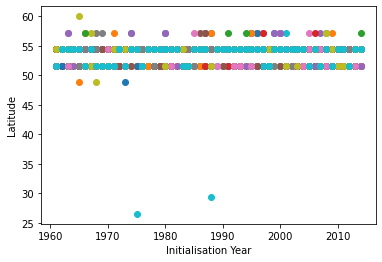

In [39]:
# Plot a scatter plot of the indices
# with the initialisation years on the x-axis
# and the indices on the y-axis
for i in range(swj_index.shape[0]):
    plt.scatter(init_years, swj_index[i, :], label=f"Member {i+1}")

plt.xlabel("Initialisation Year")
plt.ylabel("Latitude")

Text(0.05, 0.95, 'Slope: 0.01')

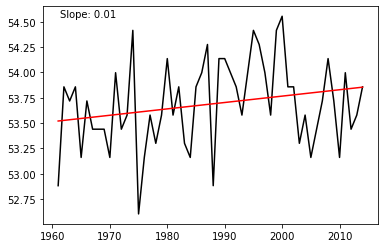

In [44]:
# Calculate the mean and standard deviation
mean = np.mean(swj_index, axis=0)

# Plot the mean
plt.plot(init_years, mean, label="dcppA", color="black")

# Include a trend line
z = np.polyfit(init_years, mean, 1)
p = np.poly1d(z)
plt.plot(init_years, p(init_years), label="Trend", color="red")

# Include the slope of the trend line
plt.text(0.05, 0.95, f"Slope: {z[0]:.2f}", transform=plt.gca().transAxes)

In [ ]:
# Regrid the hincast to 2.5x2.5 grid
# gridtype=lonlat
# xfirst=-180
# xinc=2.5
# xsize=144
# yfirst=-90
# yinc=2.5
# ysize=72
import xesmf as xe       # regridding

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(16, 75, 5.0), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(200, 330, 5.0), {"units": "degrees_east"}),
    }
)
ds_out

In [ ]:
# Smooth to a 2.5 degree grid
ds = hindcast

(ds['lat'].max() - ds['lat'].min())/(ds['lat'].count()-1.)

In [ ]:
# Resolution of around 1.4 degrees lat
(ds['lon'].max() - ds['lon'].min())/(ds['lon'].count()-1.)

In [ ]:
# And 1.4 degrees lon
ds

In [ ]:
# Set up the regridder
ds_out = xe.util.grid_2d(-180.0, 180.0, 2.5, -90.0, 90.0, 2.5)

In [ ]:
(ds_out['lat'].values)

In [ ]:
(ds_out['lon'].values)

In [ ]:
(ds['lat'].values)

In [ ]:
(ds['lon'].values)

In [ ]:
! pip install pangeo-xesmf

In [ ]:
import xesmf as xe

In [ ]:
# Set up the regridder
# As we are working with a global dataset, we use periodic=True so that we do not get gaps along the central longitude
regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=True)

In [ ]:
# Smooth ds
ds_smooth = climpred.smoothing.spatial_smoothing_xesmf(ds, method='bilinear')

In [ ]:
# Set up arbitrary dates to get DJFM means
hindcast["lead"] = xr.cftime_range(start="1960-10-16", freq="MS", periods=hindcast.lead.size)

hindcast

In [ ]:
# Group by season - DJFM and take the mean
hindcast_ = hindcast.lead.dt.month.isin([12, 1, 2, 3])

hindcast_

# Constrain hindcast to DJFM
hindcast_djfm = hindcast.sel(lead=hindcast_)

In [ ]:
hindcast_djfm

In [ ]:
# Shift the time back by 3 months
hindcast_djfm = hindcast_djfm.shift(lead=-3)

# Resample to take the annual mean anomaly
hindcast_djfm = hindcast_djfm.resample(lead="Y").mean("lead")

In [ ]:
hindcast_djfm.lead

In [ ]:
# Reset lead to be a value
hindcast_djfm["lead"] = np.arange(1, hindcast_djfm.lead.size + 1)

# Set the attribute for the lead
hindcast_djfm.lead.attrs["units"] = "years"

In [ ]:
hindcast_djfm

In [ ]:
# Select the first lead time
hindcast_djfm_1 = hindcast_djfm.sel(lead=1)

In [ ]:
# Calculate the climatology
# Take the ensemble mean
ensemble_mean = hindcast_djfm_1.mean("member")

# Take the mean over init
climatology = ensemble_mean.mean("init")

In [ ]:
climatology

In [ ]:
# Remove the climatology from the hindcast
hindcast_djfm_1_anom = hindcast_djfm - climatology

In [ ]:
hindcast_djfm_1_anom